In [1]:
import numpy as np
import pandas as pd
import sqlalchemy as sa
from sqlalchemy import create_engine

covid_measures = pd.read_csv("../Resources/COVID 19 Containment measures data.csv")
covid_measures.head(5)


,ID,Applies To,Country,Date Start,Date end intended,Description of measure implemented,Exceptions,Implementing City,Implementing State/Province,Keywords,Quantity,Source,Target city,Target country,Target region,Target state
0,163,NaN,Austria,"Mar 16, 2020",NaN,On 10 March 2020 government announced that all...,NaN,NaN,NaN,university closure,NaN,https://en.wikipedia.org/wiki/2020_coronavirus...,NaN,NaN,NaN,NaN
1,132,NaN,Germany,"Feb 01, 2020",NaN,"102 German citizens and 26 relatives, all of w...",NaN,NaN,NaN,international traveller quarantine - risk coun...,0.0001,https://www.tagesschau.de/inland/coronavirus-g...,NaN,NaN,NaN,NaN
2,578,NaN,United Kingdom,"Mar 20, 2020",NaN,"All schools, nurseries and colleges closed.",NaN,NaN,NaN,"nursery school closure, school closure, univer...",NaN,https://www.theguardian.com/world/2020/mar/18/...,NaN,NaN,NaN,NaN
3,372,NaN,United Kingdom,"Mar 16, 2020",NaN,If one person in any household has a persisten...,NaN,NaN,NaN,blanket isolation - symptoms,NaN,https://www.bbc.com/news/uk-51920444,NaN,NaN,NaN,NaN
4,357,NaN,United Kingdom,"Mar 16, 2020",NaN,"By the weekend, those with the most serious he...",NaN,NaN,NaN,isolation advice to elderly,NaN,https://www.bbc.com/news/uk-51920444,NaN,NaN,NaN,NaN


In [2]:
connection_string = "postgres:postgres@localhost:5432/covid_db"
engine = create_engine(f'postgresql://{connection_string}')
engine.table_names()

['keyword_table',
 'country_table',
 'city_table',
 'keyword_count_table',
 'keyword_trigram_table']

In [3]:
covid_measures.columns

Index(['ID', 'Applies To', 'Country', 'Date Start', 'Date end intended',
       'Description of measure implemented', 'Exceptions', 'Implementing City',
       'Implementing State/Province', 'Keywords', 'Quantity', 'Source',
       'Target city', 'Target country', 'Target region', 'Target state'],
      dtype='object')

In [4]:
covid_measures.rename(columns={'Keywords':'keywords'}, inplace=True)

keyword_df = pd.DataFrame(covid_measures.groupby('keywords').count())
keyword_df = keyword_df['Country']
keyword_df = pd.DataFrame(keyword_df.sort_values( ascending=False))
# .head(10)
# keyword_df['val_count']=keyword_df.index
keyword_df['val_count']=keyword_df['Country']
del keyword_df['Country']

keyword_df

,val_count
keywords,
school closure,74
international travel ban - risk countries,73
outdoor gatherings banned,72
testing numbers total,65
sports cancellation,38
...,...
"public hygiene, public transport limited",1
essential public service,1
"epidemic data, public hygiene",1


In [5]:
keyword_df.dropna(how='any', inplace=True)
keyword_df.to_sql(name='keyword_table', con=engine, if_exists='append', index=True)

In [3]:
covid_measures.rename(columns={'Country':'country'}, inplace=True)
country_df = pd.DataFrame(covid_measures.groupby('country').count())
country_df = country_df['keywords']
country_df = pd.DataFrame(country_df.sort_values(ascending=False))

country_df['val_count']=country_df['keywords']
del country_df['keywords']

country_df

,val_count
country,
China,121
Italy,80
South Korea,63
Singapore,60
Nepal,54
...,...
Kuwait,1
Guernsey,1
Costa Rica,1


In [18]:
country_df.dropna(how='any', inplace=True)
country_df.to_sql(name='country_table', con=engine, if_exists='append', index=True)

NameError: name 'country_df' is not defined

In [4]:
covid_measures.rename(columns={'Implementing City':'city'}, inplace=True)
city_df= pd.DataFrame(covid_measures.groupby('city').count())
city_df = city_df['country']
city_df= pd.DataFrame(city_df.sort_values(ascending=False))
city_df['val_count'] = city_df['country']
del city_df['country']


In [20]:
city_df.dropna(how='any', inplace=True)
city_df.to_sql(name='city_table', con=engine, if_exists='append', index=True)

NameError: name 'city_df' is not defined

In [6]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords') 

measures_tokenized = covid_measures['keywords'].astype(str).apply(nltk.word_tokenize)

token_corpus = np.concatenate(measures_tokenized)

stopWords = set(stopwords.words('english'))

corpusFiltered = []
 
for w in token_corpus:
    if w.lower() not in stopWords:
        if w.lower().isalpha():
            corpusFiltered.append(w.lower())
 
# print(corpusFiltered)
fd = nltk.FreqDist(corpusFiltered)
# print(fd)
fd_df= pd.DataFrame(fd, index=["val_count"])
fd_df=fd_df.transpose().sort_values(by='val_count', ascending=False)
fd_df

[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>
[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


,val_count
closure,246
international,205
isolation,198
countries,198
public,174
...,...
cashless,1
stricter,1
opening,1
hours,1


In [22]:
fd_df.dropna(how='any', inplace=True)
# fd_df.set_index(['word','val_count'])
# fd_df['word'] = fd_df.index
# fd_df
fd_df=pd.DataFrame(fd_df.reset_index())
# fd_df
fd_df.rename(columns={'index':'word'}, inplace=True)
fd_df.reset_index()

fd_df.to_sql(name='keyword_count_table', con=engine, if_exists='append', index=False)


NameError: name 'fd_df' is not defined

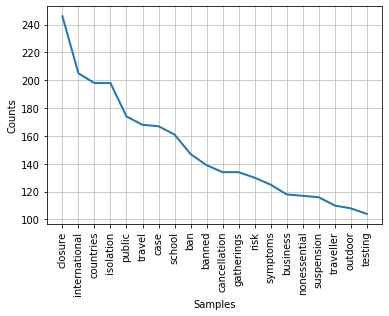

In [7]:
fd.plot(20)

In [9]:

from nltk import ngrams

trigrams = ngrams(
corpusFiltered , 3)

fdist = pd.DataFrame(nltk.FreqDist(trigrams), index=["val_count"])

fdist=pd.DataFrame(fdist.transpose().sort_values('val_count', ascending=False))
fdist.index
fdist = pd.DataFrame(fdist.reset_index())
fdist.columns
fdist['trigram'] = fdist['level_0'].str.cat(fdist['level_1'],sep=" ").str.cat(fdist['level_2'],sep=" ")
del fdist['level_0']
del fdist['level_1']
del fdist['level_2']



# fdist.to_sql(name='keyword_trigram_table', con=engine, if_exists='append', index=False)
fdist

,val_count,trigram
0,113,nonessential business suspension
1,112,international travel ban
2,108,outdoor gatherings banned
3,73,ban risk countries
4,73,travel ban risk
...,...,...
2397,1,limited international travel
2398,1,transport limited international
2399,1,work public transport
2400,1,remote work public
